Creating RawArray with float64 data, n_channels=14, n_times=2262
    Range : 0 ... 2261 =      0.000 ...    17.664 secs
Ready.
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
           PSD  DeltaPower  ThetaPower  AlphaPower  BetaPower
AF3   2.841450    7.143568    3.903266    9.912132   1.859714
F7    5.074713   18.001942   15.453830   14.887953   2.691155
F3   19.380097  167.114523  132.319931   12.955981   2.516379
FC5   3.758216   13.822638    5.088532   10.414023   2.352418
T7    2.868772   11.642177    6.945036    7.932889   1.564237
P7    2.334220    7.26491

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

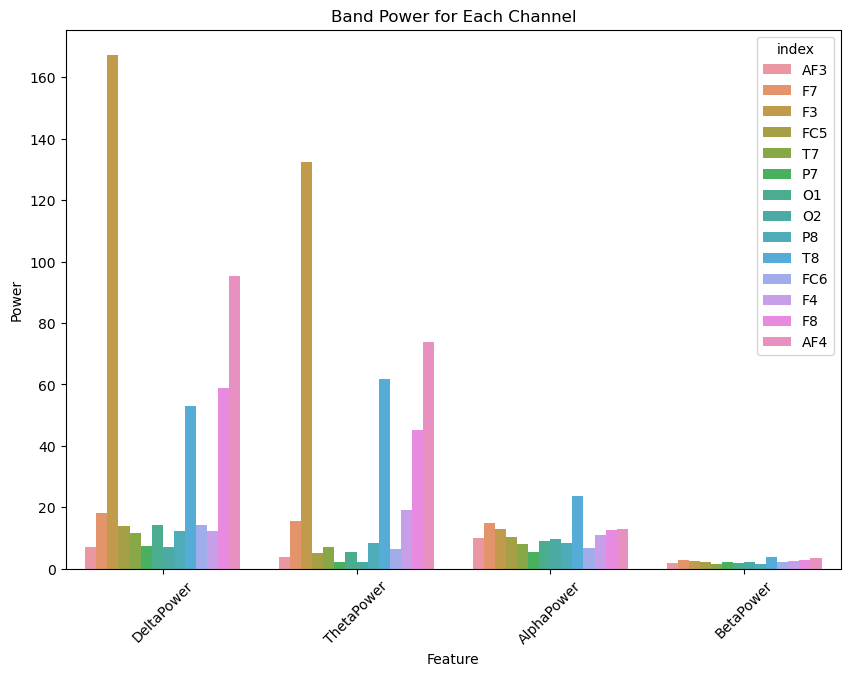

In [4]:
#↑の特徴量強化のプログラム（パワースペクトル分析）
import mne
import numpy as np
import pandas as pd

# CSVファイルからデータを読み込む
data = pd.read_csv('epoc_X_data_clean_auto_v1.csv')

# 'timestamp'列を削除
data.drop('timestamp', axis=1, inplace=True)

# CSVファイルの列名（チャンネル名）を取得
ch_names = data.columns.tolist()

# サンプリング周波数を設定
sfreq = 128

# データをMNEのRawオブジェクトに変換
raw = mne.io.RawArray(data.T, mne.create_info(ch_names, sfreq))

# 周波数帯を定義
bands = {'Delta': [0.5, 4],
         'Theta': [4, 8],
         'Alpha': [8, 13],
         'Beta': [13, 30]}

# 特徴量を格納するためのデータフレームを作成
features = pd.DataFrame(index=ch_names)

# 各チャンネルについてパワースペクトル密度（PSD）とバンドパワーを計算
for ch in ch_names:
    psd, freqs = mne.time_frequency.psd_array_welch(raw.get_data(picks=ch), sfreq, fmin=0.5, fmax=45)
    psd = psd[0]  # psd_array_welch returns a list

    # PSDを特徴量として追加
    features.loc[ch, 'PSD'] = np.mean(psd)

    # 各バンドのパワーを計算
    for band, freq_range in bands.items():
        mask = np.logical_and(freqs >= freq_range[0], freqs <= freq_range[1])
        features.loc[ch, f'{band}Power'] = np.mean(psd[mask])

# 結果を表示
print(features)

import matplotlib.pyplot as plt
import seaborn as sns

# 特徴量のデータフレームを準備
df_melt = features.reset_index().melt(id_vars='index', var_name='Feature', value_name='Value')

# バンドパワーのみを選択
df_bandpower = df_melt[df_melt['Feature'].str.contains('Power')]

# バンドパワーのプロット
plt.figure(figsize=(10,7))
sns.barplot(x='Feature', y='Value', hue='index', data=df_bandpower)
plt.title('Band Power for Each Channel')
plt.ylabel('Power')
plt.xticks(rotation=45)
plt.show()

In [3]:
#PSDの結果をcsvファイルに書き出す
# CSVファイルからデータを読み込む
data = pd.read_csv('epoc_X_data_clean_auto_v1.csv')

# チャンネル名を取得（'timestamp'を除く）
ch_names = [col for col in data.columns if col != 'timestamp']

# サンプリング周波数を設定
sfreq = 128

# 周波数帯を定義（ガンマ波を除く）
bands = {'Delta': [0.5, 4],
         'Theta': [4, 8],
         'Alpha': [8, 13],
         'Beta': [13, 30]}

# 各チャンネルについて処理
for ch in ch_names:
    # データをMNEのRawオブジェクトに変換
    raw = mne.io.RawArray([data[ch]], mne.create_info([ch], sfreq), verbose=False)

    # パワースペクトル密度（PSD）を計算
    psd, freqs = mne.time_frequency.psd_array_welch(raw.get_data(), sfreq, fmin=0.5, fmax=45, verbose=False)
    psd = psd[0]  # psd_array_welch returns a list

    # 各バンドのパワーを計算し、データフレームに追加
    for band, freq_range in bands.items():
        mask = np.logical_and(freqs >= freq_range[0], freqs <= freq_range[1])
        data[f'{band}Power_{ch}'] = np.mean(psd[mask])

# 結果をCSVファイルに書き出す
data.to_csv('epoc_X_data_with_PSDfeatures.csv', index=False)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 845 samples (6.602 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.

- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 213 samples (1.664 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 131 samples (1.023 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

- Filter length: 213 samples (1.664 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 131 samples (1.023 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cuto

- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 213 samples (1.664 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

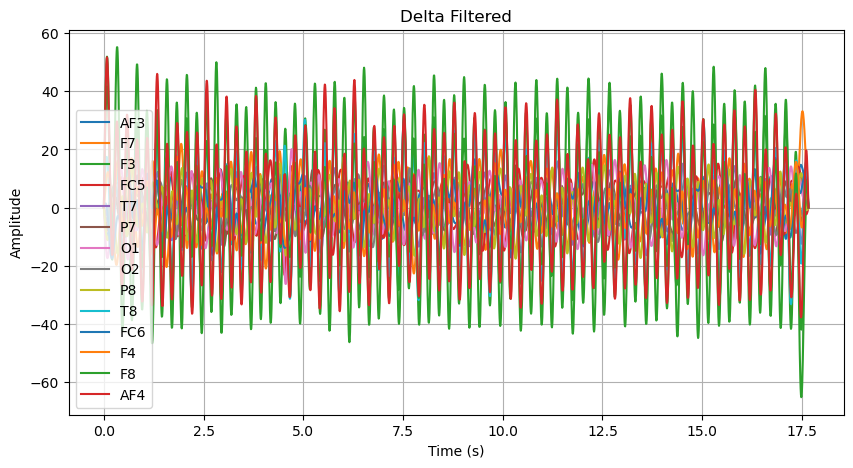

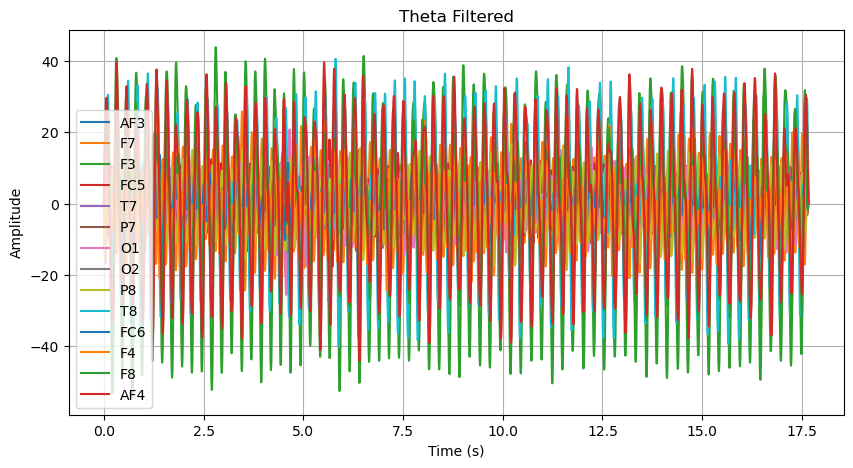

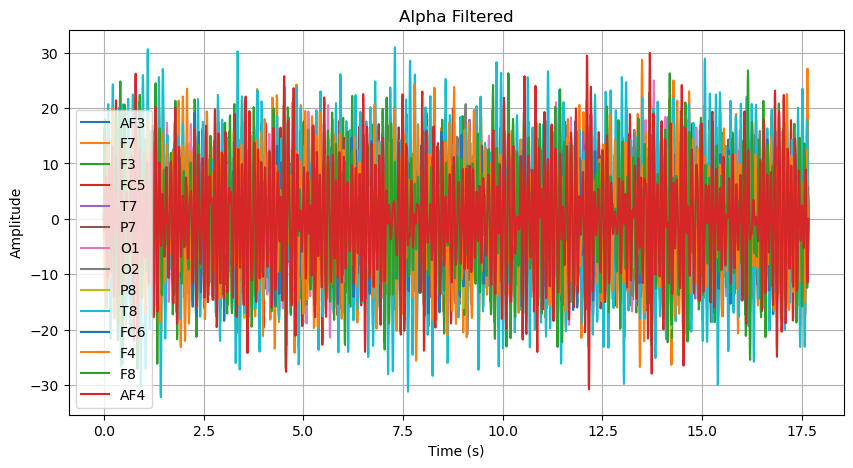

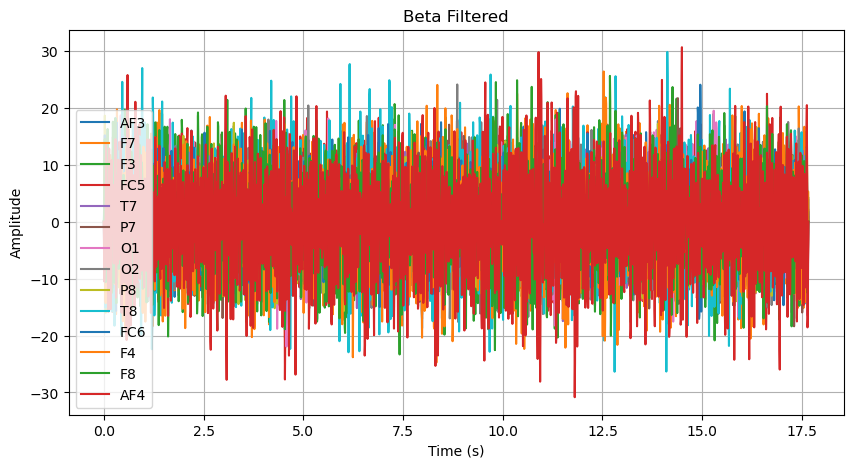

In [7]:
#もとのデータにバンドパスフィルタを適用し、csvファイルに保存
# CSVファイルからデータを読み込む
data = pd.read_csv('epoc_X_data_clean_auto_v1.csv')

# チャンネル名を取得（'timestamp'を除く）
ch_names = [col for col in data.columns if col != 'timestamp']

# サンプリング周波数を設定
sfreq = 128

# バンドパスフィルタの範囲を定義
bands = {'Delta': [0.5, 4],
         'Theta': [4, 8],
         'Alpha': [8, 13],
         'Beta': [13, 30]}

# 各チャンネルについて処理
for ch in ch_names:
    # データをMNEのRawオブジェクトに変換
    raw = mne.io.RawArray([data[ch]], mne.create_info([ch], sfreq, ch_types='eeg'), verbose=False)

    # 各バンドに対してバンドパスフィルタを適用し、新しい列を作成
    for band, freq_range in bands.items():
        filtered_data = raw.copy().filter(l_freq=freq_range[0], h_freq=freq_range[1]).get_data()[0]
        data[f'{band}Filtered_{ch}'] = filtered_data

# 各バンドについてプロット
for band in bands.keys():
    plt.figure(figsize=(10, 5))
    
    # 各チャンネルをプロット
    for ch in ch_names:
        plt.plot(data['timestamp'], data[f'{band}Filtered_{ch}'], label=ch)
    
    plt.title(f'{band} Filtered')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()
    plt.show()